## Experimenting with Neural Networks

In [1]:
import numpy as np
from glob import glob

# from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image 
from keras.utils import np_utils
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  

from tqdm import tqdm

# custom functions
from layer_output import get_dense_layer, all_dense_data
from loading import load_files       

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


**Get the data from train, validate, test and create a target label** 

In [3]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path, ignore_files='.DS_Store')
    clothing_files = np.array(data['filenames'])
    clothing_targets = np_utils.to_categorical(np.array(data['target']), 6)
    return clothing_files, clothing_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/clothing/train')
valid_files, valid_targets = load_dataset('../data/clothing/validate')
test_files, test_targets = load_dataset('../data/clothing/test')

# load list of clothing names
clothing_names = [item[23:-1] for item in sorted(glob("../data/clothing/train/*/"))]

# print info about the dataset
print(f'There are {len(clothing_names)} total clothing categories.')
print(f'There are {len(np.hstack([train_files, valid_files, test_files]))} total clothing images.\n')
print(f'There are {len(train_files)} training clothing images.')
print(f'There are {len(valid_files)} validation clothing images.')
print(f'There are {len(test_files)} test clothing images.')

There are 6 total clothing categories.
There are 1302 total clothing images.

There are 1042 training clothing images.
There are 128 validation clothing images.
There are 132 test clothing images.


In [4]:
clothing_names

['black_dresses',
 'black_pants',
 'black_shorts',
 'blue_dresses',
 'red_dresses',
 'tank_tops']

In [5]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
# rescale the images by dividing every pixel in every image by 255.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 132/132 [00:00<00:00, 269.64it/s]


In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()

# Define the architecture.
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=5, strides =2, padding='valid', activation='relu', 
                 input_shape=(223, 223, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=5, strides =2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=150, activation='relu', name='vectors')) # extract vectors from here and cluster
model.add(Dropout(rate=0.3))
model.add(Dense(len(clothing_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [8]:
# compile the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_train.fit(train_tensors)

In [10]:
epochs = 30
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 1042 samples, validate on 128 samples
Epoch 1/30
1042/1042 [==============================] - 8s 8ms/step - loss: 1.4881 - acc: 0.3983 - val_loss: 1.1887 - val_acc: 0.4922

Epoch 00001: val_loss improved from inf to 1.18871, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/30
1042/1042 [==============================] - 7s 7ms/step - loss: 1.1990 - acc: 0.5298 - val_loss: 1.1978 - val_acc: 0.5078

Epoch 00002: val_loss did not improve from 1.18871
Epoch 3/30
1042/1042 [==============================] - 7s 6ms/step - loss: 1.0415 - acc: 0.6056 - val_loss: 0.9211 - val_acc: 0.6719

Epoch 00003: val_loss improved from 1.18871 to 0.92110, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/30
1042/1042 [==============================] - 6s 6ms/step - loss: 0.9518 - acc: 0.6622 - val_loss: 1.0419 - val_acc: 0.5703

Epoch 00004: val_loss did not improve from 0.92110
Epoch 5/30
1042/1042 [==============================] - 7s 6ms/step - loss: 0.8434 

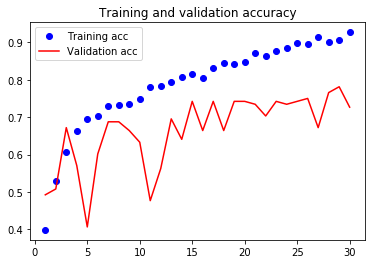

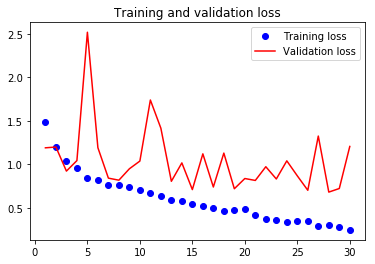

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', c='red')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')
plt.title('Training and validation loss')
plt.legend();

In [12]:
# get index of predicted item for each image in test set
clothing_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(clothing_predictions)==np.argmax(test_targets, axis=1))/len(clothing_predictions)
print('Test accuracy: {}'.format(round(test_accuracy), 4))

Test accuracy: 76.0


In [ ]:
# # https://github.com/keras-team/keras/issues/3465
# output = model.get_layer('vectors').output

# # https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
# # load the model with best validation loss
# model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# model.save('saved_models/clothes_cnn.h5')


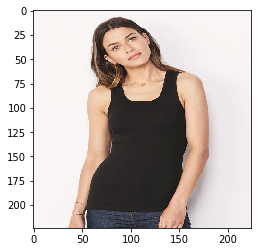

(1, 224, 224, 3)


In [18]:
img_path = '../data/clothing/test/tank_tops/tank_tops133.jpg'
img_tensor = path_to_tensor(img_path)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [19]:
# predicting images
images = np.vstack([img_tensor])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:", clothing_names[int(classes)])

Predicted class is: black_dresses


In [20]:
all_train_dense = all_dense_data(model, train_files, num_layer=8)
all_train_dense.shape

(1042, 150)

In [ ]:
# all_train_dense

In [ ]:
# pca_2d.var(axis=0)
# all_train_dense.var(axis=0).max()

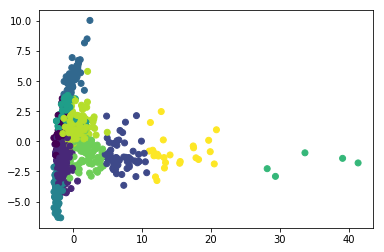

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl

X = all_train_dense
targets = np.array([np.where(target == 1)[0][0] for target in train_targets])

pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
kmeans = KMeans(n_clusters=10, random_state=11)
kmeans.fit(X)
pl.figure('K-means with 10 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_);

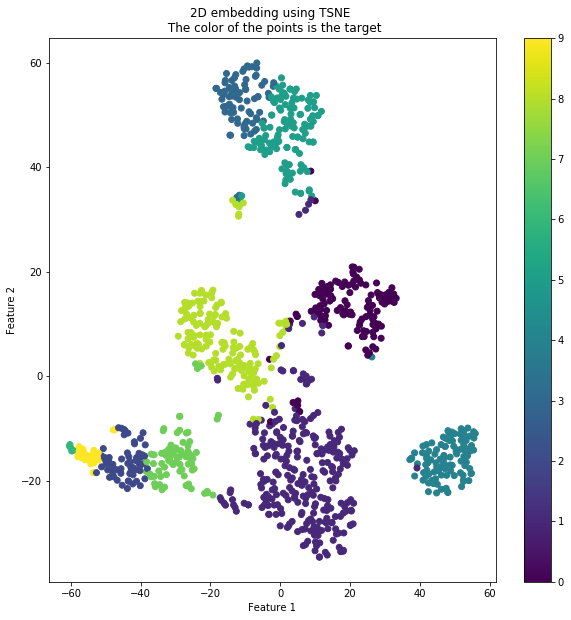

<Figure size 432x288 with 0 Axes>

In [23]:
# https://datascience.stackexchange.com/questions/31700/how-to-print-kmeans-cluster-python
from sklearn.manifold import TSNE

X = all_train_dense
targets = np.array([np.where(target == 1)[0][0] for target in train_targets])

# Embed the features into 2 features using TSNE
X_embedded_tsne = TSNE(n_components=2, perplexity=25).fit_transform(X)

plt.figure(figsize=(10,10))
plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], c = kmeans.labels_)
plt.title('2D embedding using TSNE \n The color of the points is the target')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()
plt.tight_layout()

In [24]:
for cluster_num in range(10):
    mask = np.where(kmeans.labels_ == cluster_num)[0]
    for idx in mask:
        print(f"Image {train_files[idx]} is in cluster: {cluster_num}")

Image ../data/clothing/train/black_shorts/black_shorts125.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts148.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts119.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts106.jpg is in cluster: 0
Image ../data/clothing/train/red_dresses/red_dresses195.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts146.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts26.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts73.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts17.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts94.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts24.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts54.jpg is in cluster: 0
Image ../data/clothing/train/black_shorts/black_shorts79.jpg

In [26]:
# number of iamges in each cluster
[np.where(kmeans.labels_ == cluster_num, 1, 0).sum() for cluster_num in range(10)]

[127, 285, 61, 78, 104, 124, 5, 75, 158, 25]

In [29]:
# create a confusion matrix out of the the labels and clusters
confusion = dict()

for target, label in zip(targets, kmeans.labels_):
    confusion[(target, label)] = confusion.get((target, label), 0) + 1

for target in range(6):
    line = '  '.join([f'{confusion.get((target,label),0):3d}' for label in range(10)])
    print(line)    

  7  239    0    0    1    1    0    1    0    0
  0    3    0    0  101    0    0    0    0    0
112    6    0    0    2    2    0    0    0    0
  0    4   52    0    0    0    5   60    0   23
  2    1    0   73    0  119    0    0    0    0
  6   32    9    5    0    2    0   14  158    2


In [28]:
clothing_names

['black_dresses',
 'black_pants',
 'black_shorts',
 'blue_dresses',
 'red_dresses',
 'tank_tops']

In [32]:
def view_image(image_path):
    plt.imshow(path_to_tensor(image_path)[0]/255.)

**NOTES**
* cluster 0 - some red in non-dress images, 
* cluster 1 - Too many
* cluster 2 - Short blue dresses
* cluster 3 - all red dresses 
* cluster 4 - image with no head or head has been cut off 
* cluster 5 - all red dresses
* cluster 6 - bent elbows or hands on the hip
* cluster 7 - blue dresses misplaced as black / rest short blue dresses
* cluster 8 - black shorts, no model/human OR Black dress with flare at the bottom
* cluster 9 - short blue dresses or split (double) image

In [42]:
path1 = '../data/clothing/train/black_shorts/black_shorts33.jpg'
path2 = '../data/clothing/train/black_shorts/black_shorts130.jpg'

path3 = '../data/clothing/train/black_shorts/black_shorts50.jpg'
path4 = '../data/clothing/train/black_dresses/black_dresses233.jpg'

path5 = '../data/clothing/train/red_dresses/red_dresses196.jpg'
path6 = '../data/clothing/train/red_dresses/red_dresses75.jpg'
path7 = '../data/clothing/train/red_dresses/red_dresses153.jpg'
path8 = '../data/clothing/train/red_dresses/red_dresses145.jpg'
path9 = '../data/clothing/train/red_dresses/red_dresses178.jpg'


path10 = '../data/clothing/train/red_dresses/red_dresses168.jpg'

path11 = '../data/clothing/train/black_dresses/black_dresses65.jpg'
path12 = '../data/clothing/train/black_dresses/black_dresses244.jpg'
path13 = '../data/clothing/train/black_dresses/black_dresses162.jpg'
path14 = '../data/clothing/train/black_dresses/black_dresses114.jpg'

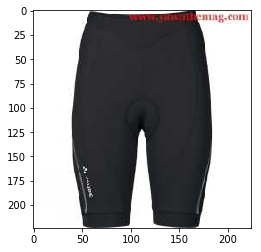

In [37]:
view_image(path1)

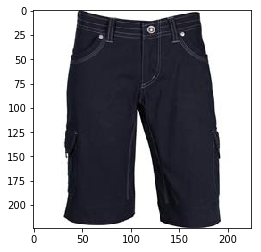

In [39]:
view_image(path2)

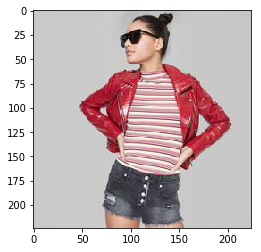

In [41]:
view_image(path3)

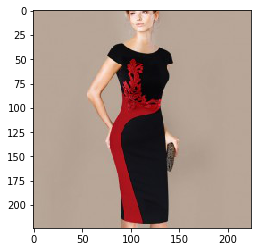

In [43]:
view_image(path4)

In [ ]:
view_image(path5)

In [ ]:
view_image(path6)

In [ ]:
view_image(path7)

In [ ]:
view_image(path8)

In [ ]:
view_image(path9)

In [ ]:
view_image(path10)

In [ ]:
view_image(path11)

In [ ]:
view_image(path12)

In [ ]:
view_image(path13)

In [ ]:
view_image(path14)

In [ ]:
# look up auto labeling tools